In [1]:
# Cell 0
!pip -q install --upgrade tensorflow keras

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42); tf.random.set_seed(42)

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
TF: 2.20.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mounted at /content/drive


In [2]:
# Cell 1
BASE_DIR = "/content/drive/MyDrive/Images/Images"
POS_DIR  = os.path.join(BASE_DIR, "Appendicitis_Images")       # label 1
NEG_DIR  = os.path.join(BASE_DIR, "No_Appendicitis_Images")    # label 0

def list_images(d):
    if not os.path.isdir(d): return []
    exts = (".bmp",".jpg",".jpeg",".png")
    return [os.path.join(d,f) for f in os.listdir(d) if f.lower().endswith(exts)]

pos_files = sorted(list_images(POS_DIR))
neg_files = sorted(list_images(NEG_DIR))

print("pos:", len(pos_files), "| neg:", len(neg_files))
assert len(pos_files)+len(neg_files) > 0, "No images found. Check paths."


pos: 1339 | neg: 382


In [3]:
# Cell 2
all_files  = np.array(pos_files + neg_files)
all_labels = np.array([1]*len(pos_files) + [0]*len(neg_files))

X_train, X_temp, y_train, y_temp = train_test_split(
    all_files, all_labels, test_size=0.30, random_state=42, stratify=all_labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

def bincount_info(y, name):
    unique, counts = np.unique(y, return_counts=True)
    d = dict(zip(unique, counts))
    print(f"{name} -> class0:{d.get(0,0)}  class1:{d.get(1,0)}  total:{len(y)}")

bincount_info(y_train, "Train (before OS)")
bincount_info(y_val,   "Val")
bincount_info(y_test,  "Test")


Train (before OS) -> class0:267  class1:937  total:1204
Val -> class0:57  class1:201  total:258
Test -> class0:58  class1:201  total:259


In [4]:
# Cell 3
rng = np.random.default_rng(42)
idx_pos = np.where(y_train == 1)[0]
idx_neg = np.where(y_train == 0)[0]
n_pos, n_neg = len(idx_pos), len(idx_neg)
n_major = max(n_pos, n_neg)

idx_pos_os = rng.choice(idx_pos, size=n_major, replace=True) if n_pos < n_major else idx_pos
idx_neg_os = rng.choice(idx_neg, size=n_major, replace=True) if n_neg < n_major else idx_neg

idx_os = np.concatenate([idx_pos_os, idx_neg_os])
rng.shuffle(idx_os)

X_train_os = X_train[idx_os]
y_train_os = y_train[idx_os]

bincount_info(y_train,    "Train  (before OS)")
bincount_info(y_train_os, "Train* (after  OS)")


Train  (before OS) -> class0:267  class1:937  total:1204
Train* (after  OS) -> class0:937  class1:937  total:1874


In [5]:
# Cell 4
IMG_SIZE = (224, 224)
BATCH    = 16

AUTOTUNE = tf.data.AUTOTUNE

def parse_example(path, label):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [1])  # <- ensures (batch,1) later (fixes F1 2D requirement)
    return img, label

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=min(len(paths), 2000), reshuffle_each_iteration=True)
    ds = ds.map(parse_example, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH, drop_remainder=False)
    ds = ds.prefetch(AUTOTUNE)   # no .cache() -> keeps RAM usage low
    return ds

train_ds = make_ds(X_train_os, y_train_os, training=True)
val_ds   = make_ds(X_val,      y_val,      training=False)
test_ds  = make_ds(X_test,     y_test,     training=False)

for xb, yb in train_ds.take(1):
    print("Batch shapes:", xb.shape, yb.shape)


Batch shapes: (16, 224, 224, 3) (16, 1)


In [6]:
# Cell 5
from tensorflow.keras.applications import DenseNet121
from keras.metrics import F1Score  # Keras 3 metric

def build_model(input_shape=(224,224,3)):
    base = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    base.trainable = False
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        base,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            F1Score(name="f1", threshold=0.5, average="micro"),
        ],
    )
    return model

model = build_model()
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,697,985 (29.37 MB)

 Trainable params: 658,433 (2.51 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [7]:
# Cell 6
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

callbacks_phase1 = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_phase1.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
]


In [8]:
# Cell 7
print("Starting Phase 1 (frozen backbone, oversampled train, NO augmentation)...")
hist1 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=callbacks_phase1,
    verbose=1
)
print("Phase 1 done.")


Starting Phase 1 (frozen backbone, oversampled train, NO augmentation)...
Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6036 - f1: 0.5766 - loss: 0.7622 - precision: 0.5889 - recall: 0.5651
Epoch 1: val_accuracy improved from None to 0.64729, saving model to best_phase1.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.6601 - f1: 0.6551 - loss: 0.6706 - precision: 0.6648 - recall: 0.6457 - val_accuracy: 0.6473 - val_f1: 0.7331 - val_loss: 0.6291 - val_precision: 0.8929 - val_recall: 0.6219 - learning_rate: 0.0010
Epoch 2/20
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7381 - f1: 0.7395 - loss: 0.5453 - precision: 0.7425 - recall: 0.7378
Epoch 2: val_accuracy improved from 0.64729 to 0.70543, saving model to best_phase1.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.7561 - f1: 0.7550 - loss: 0.5054 - precision: 0.7586 - recall: 0.7513 - val_accuracy: 0.7054 - val_f1: 0.8021 - val_loss: 0.5540 - val_precision: 0.8415 - val_recall

In [9]:
# === Cell 8 (fixed): Unfreeze tail & recompile ===
from keras.metrics import F1Score
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# 1) Grab the backbone safely
try:
    base_model = model.layers[0]  # In your Sequential, index 0 is DenseNet201 backbone
except Exception as e:
    # Fallback: search by name (denseNet/efficientNet/etc.)
    base_model = None
    for lyr in model.layers:
        if hasattr(lyr, "layers") and ("densenet" in lyr.name.lower() or "efficientnet" in lyr.name.lower()):
            base_model = lyr
            break
    if base_model is None:
        raise RuntimeError("Backbone not found. Inspect model.layers to locate the base CNN.") from e

print("Backbone:", base_model.name, "| inner layers:", len(getattr(base_model, "layers", [])))

# 2) Unfreeze the last N layers of the backbone
unfreeze_last = 4  # tweak as you like
for lyr in base_model.layers[:-unfreeze_last]:
    lyr.trainable = False
for lyr in base_model.layers[-unfreeze_last:]:
    lyr.trainable = True

# 3) Recompile
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        F1Score(name="f1", threshold=0.5, average="micro"),
    ],
)

# 4) Callbacks for phase 2
callbacks_phase2 = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('best_phase2.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
]

print("Fine-tuning setup complete. Base trainable tail:", sum(int(l.trainable) for l in base_model.layers), "of", len(base_model.layers))


Backbone: densenet121 | inner layers: 427
Fine-tuning setup complete. Base trainable tail: 4 of 427


In [10]:
# Cell 9
print("Starting Phase 2 (fine-tuning tail, oversampled train, NO augmentation)...")
hist2 = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=callbacks_phase2,
    verbose=1
)
print("Phase 2 done.")


Starting Phase 2 (fine-tuning tail, oversampled train, NO augmentation)...
Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9829 - f1: 0.9826 - loss: 0.0468 - precision: 0.9866 - recall: 0.9786
Epoch 1: val_accuracy improved from None to 0.80233, saving model to best_phase2.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 406ms/step - accuracy: 0.9877 - f1: 0.9877 - loss: 0.0383 - precision: 0.9903 - recall: 0.9851 - val_accuracy: 0.8023 - val_f1: 0.8771 - val_loss: 0.9628 - val_precision: 0.8505 - val_recall: 0.9055 - learning_rate: 1.0000e-04
Epoch 2/15
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9877 - f1: 0.9876 - loss: 0.0484 - precision: 0.9846 - recall: 0.9906
Epoch 2: val_accuracy did not improve from 0.80233
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - accuracy: 0.9819 - f1: 0.9819 - loss: 0.0542 - precision: 0.9819 - recall: 0.9819 - val_accuracy: 0.7829 - val_f1: 0.8654 - val_loss: 0.9508 - val_precision: 0.8372 - val_recall: 0.8955 - learning_rate: 1.

Evaluating on TEST...
loss: 1.1848
compile_metrics: 0.7722

Classification Report:
                 precision    recall  f1-score   support

No Appendicitis       0.49      0.29      0.37        58
   Appendicitis       0.82      0.91      0.86       201

       accuracy                           0.77       259
      macro avg       0.65      0.60      0.61       259
   weighted avg       0.74      0.77      0.75       259



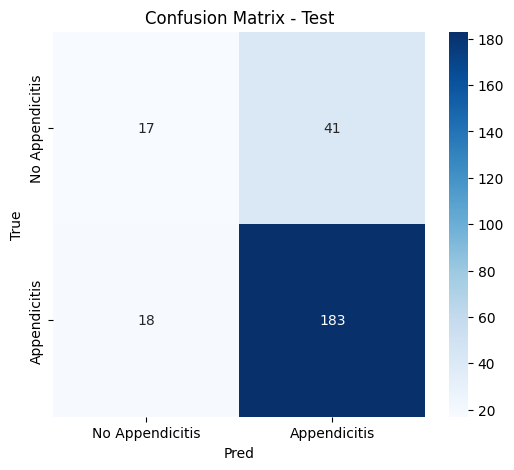

Sensitivity: 0.910  Specificity: 0.293  F1: 0.861


In [11]:
# Cell 10
print("Evaluating on TEST...")
test_metrics = model.evaluate(test_ds, verbose=0)
metric_names = model.metrics_names
for n,v in zip(metric_names, test_metrics):
    print(f"{n}: {v:.4f}")

# Collect predictions for sklearn report
y_true = []
y_prob = []
for xb, yb in test_ds:
    y_true.append(yb.numpy().reshape(-1))     # (batch,1) -> (-1,)
    y_prob.append(model.predict(xb, verbose=0).reshape(-1))
y_true = np.concatenate(y_true)
y_prob = np.concatenate(y_prob)
y_pred = (y_prob > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, f1_score
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['No Appendicitis','Appendicitis']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Appendicitis','Appendicitis'],
            yticklabels=['No Appendicitis','Appendicitis'])
plt.title('Confusion Matrix - Test'); plt.ylabel('True'); plt.xlabel('Pred'); plt.show()

tn, fp, fn, tp = cm.ravel()
sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
print(f"Sensitivity: {sens:.3f}  Specificity: {spec:.3f}  F1: {f1_score(y_true,y_pred):.3f}")



Additional Evaluation Metrics:
Macro F1 Score: 0.6134
AUC (ROC): 0.7141


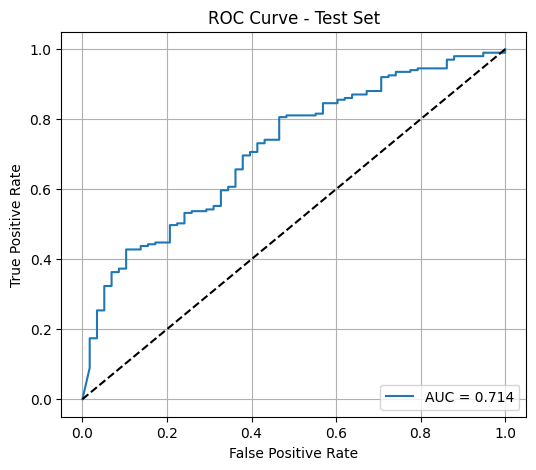

In [13]:
# === Additional Metrics: Macro F1 and AUC (fixed for tf.data pipeline) ===
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Ensure 1-D arrays
y_true_1d = np.asarray(y_true).ravel()
y_prob_1d = np.asarray(y_prob).ravel()
y_pred_1d = np.asarray(y_pred).ravel()

# Macro-F1 (equal weight for both classes) → use hard labels
macro_f1 = f1_score(y_true_1d, y_pred_1d, average='macro')

# AUC must use probabilities, not hard labels
auc = roc_auc_score(y_true_1d, y_prob_1d)

print("\nAdditional Evaluation Metrics:")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"AUC (ROC): {auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_true_1d, y_prob_1d)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [14]:
# Cell 11
model.save('final_appendicitis_densenet121_oversampling_stream.keras')
print("Saved: final_appendicitis_densenet121_oversampling_stream.keras")

# Save model architecture as JSON
model_json = model.to_json()
with open("appendicitis_model_architecture_oversampling.json", "w") as json_file:
    json_file.write(model_json)

# Save only the weights
model.save_weights("appendicitis_model_weights_oversampling.weights.h5")
print("Model architecture and weights saved separately")



Saved: final_appendicitis_densenet121_oversampling_stream.keras
Model architecture and weights saved separately


In [15]:
import os, shutil

# === Define your model-specific subfolder ===
model_name = "DenseNet121_oversampling"  # 👈 change for each model if needed

# === Create the nested directory in Drive ===
save_dir = f"/content/drive/MyDrive/Appendicitis_Models/{model_name}"
os.makedirs(save_dir, exist_ok=True)

# === Copy all your key files into that subfolder ===
for f in [
    "final_appendicitis_densenet121_oversampling_stream.keras",
    "appendicitis_model_weights_oversampling.weights.h5",
    "appendicitis_model_architecture_oversampling.json"
]:
    if os.path.exists(f):
        shutil.copy(f, save_dir)
        print(f"✅ Saved: {f} → {save_dir}")
    else:
        print(f"⚠️ File not found: {f}")

print(f"\nAll files safely stored in: {save_dir}")


✅ Saved: final_appendicitis_densenet121_oversampling_stream.keras → /content/drive/MyDrive/Appendicitis_Models/DenseNet121_oversampling
✅ Saved: appendicitis_model_weights_oversampling.weights.h5 → /content/drive/MyDrive/Appendicitis_Models/DenseNet121_oversampling
✅ Saved: appendicitis_model_architecture_oversampling.json → /content/drive/MyDrive/Appendicitis_Models/DenseNet121_oversampling

All files safely stored in: /content/drive/MyDrive/Appendicitis_Models/DenseNet121_oversampling
